# 机器学习实验报告-lab3-参数估计&非参数估计
**姓名：** 郭裕彬
**学号：** 2114052
**专业：** 物联网工程
## 实验要求
### 基本要求
生成两个各包含 N=1000 个二维随机向量的数据集合 $X_1$ 和 $X_2$，数据集合中随机向量来自于三个分布模型，分别满足均值向量 $\mu_1=[1,4]$,$\mu_2=[4,1]$, $\mu_3=[8,4]$ 和协方差矩阵 $D_1=D_2=D_3=2\pmb{I}$ ，其中$\pmb{I}$是 $2*2$的单位矩阵。在生成数据集合 $X_1$ 时，假设来自三个分布模型的先验概率相同 ；而在生成数据集合 $X_2$ 时，先验概率如下：$p(w_1)=0.6$, $p(w_2)=0.3$, $p(w_3)=0.1$
在两个数据集合上分别应用“似然率测试规则” 和“最大后验概率规则” 进行分类实验，计算分类错误率，分析实验结果。

### 中级要求
在两个数据集合上使⽤⾼斯核函数估计⽅法，应⽤“似然率测试规则”分类和“最大后验概率规则”在 [0.1, 0.5, 1, 1.5, 2] 范围内交叉验证找到最优 h 值，分析实验结果

### 高级要求
在两个数据集合上使⽤进⾏k-近邻概率密度估计，计算并分析 k=1，3，5 时的概率密度估计结果

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

## 基本要求

In [2]:
# 生成数据集 X1
np.random.seed(2114052)
N = 1000

# 均值向量和协方差矩阵
mu1 = np.array([1, 4])
mu2 = np.array([4, 1])
mu3 = np.array([8, 4])
cov_matrix = np.array([[2, 0], [0, 2]])
prior_probabilities = [0.6, 0.3, 0.1]

# 生成数据点
X1 = np.vstack([
    multivariate_normal.rvs(mu1, cov_matrix, size=int(1 / 3 * N)),
    multivariate_normal.rvs(mu2, cov_matrix, size=int(1 / 3 * N)),
    multivariate_normal.rvs(mu3, cov_matrix, size=int(1 / 3 * N))
])
X2 = np.vstack([
    multivariate_normal.rvs(mu1, cov_matrix, size=int(prior_probabilities[0] * N)),
    multivariate_normal.rvs(mu2, cov_matrix, size=int(prior_probabilities[1] * N)),
    multivariate_normal.rvs(mu3, cov_matrix, size=int(prior_probabilities[2] * N))
])

# 贴上标签
labels = np.repeat([0, 1, 2], [int(1 / 3 * N), int(1 / 3 * N), int(1 / 3 * N)])
X1 = np.column_stack((X1, labels))
labels = np.repeat([0, 1, 2], [int(prior_probabilities[0] * N), int(prior_probabilities[1] * N), int(prior_probabilities[2] * N)])
X2 = np.column_stack((X2, labels))

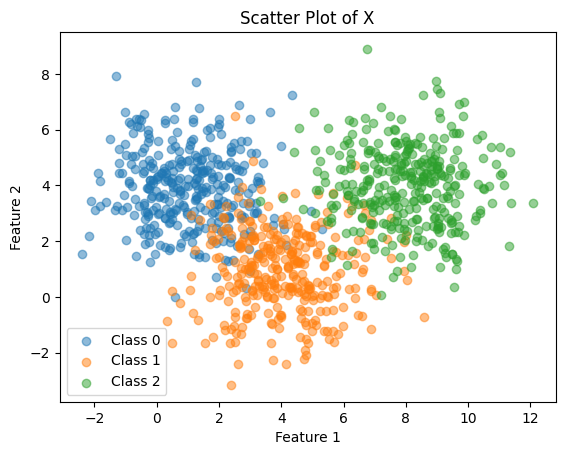

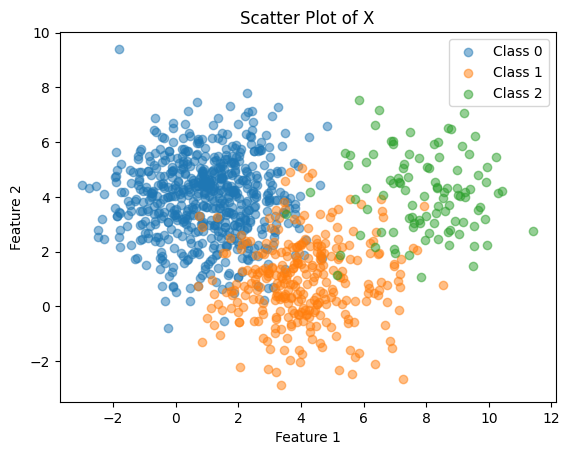

In [3]:
def draw(X):
    # 根据标签将数据分类
    class0 = X[X[:, -1] == 0]
    class1 = X[X[:, -1] == 1]
    class2 = X[X[:, -1] == 2]

    # 提取各个类别的x和y坐标
    x0 = class0[:, 0]
    y0 = class0[:, 1]
    x1 = class1[:, 0]
    y1 = class1[:, 1]
    x2 = class2[:, 0]
    y2 = class2[:, 1]

    # 绘制散点图
    plt.scatter(x0, y0, label='Class 0', alpha=0.5)
    plt.scatter(x1, y1, label='Class 1', alpha=0.5)
    plt.scatter(x2, y2, label='Class 2', alpha=0.5)

    # 设置图例
    plt.legend()

    # 添加标题和坐标轴标签
    plt.title('Scatter Plot of X')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # 显示散点图
    plt.show()


draw(X1)
draw(X2)

In [4]:
# 定义似然率测试规则
def likelihood_ratio_test(x, mu_list, cov_matrix_list, prior_probabilities):
    likelihoods = np.zeros(len(mu_list))
    number = np.array(x).shape[0]
    error_num = 0
    for k in range(number):
        n = 2
        for i in range(len(mu_list)):
            # 计算每个类别的似然函数值
            det = np.linalg.det(cov_matrix_list[i])
            inv_covariance = np.linalg.inv(cov_matrix_list[i])
            exponent = -0.5 * np.dot(np.dot((x[k][0:2] - mu_list[i]).T, inv_covariance), (x[k][0:2] - mu_list[i]))
            coefficient = 1.0 / ((2 * np.pi) ** (n / 2) * np.sqrt(det))
            likelihoods[i] = coefficient * np.exp(exponent)
        #判断对该点的分类结果
        if np.argmax(likelihoods) != x[k][2]:
            error_num += 1
    return error_num / number


# 定义最大后验概率测试规则
def max_posterior_test(x, mu_list, cov_matrix_list, prior_probabilities):
    maxs = np.zeros(len(mu_list))
    number = np.array(x).shape[0]
    error_num = 0
    for k in range(number):
        n = 2
        for i in range(len(mu_list)):
            # 计算每个类别的最大后验函数值
            det = np.linalg.det(cov_matrix_list[i])
            inv_covariance = np.linalg.inv(cov_matrix_list[i])
            exponent = -0.5 * np.dot(np.dot((x[k][0:2] - mu_list[i]).T, inv_covariance), (x[k][0:2] - mu_list[i]))
            coefficient = 1.0 / ((2 * np.pi) ** (n / 2) * np.sqrt(det))
            maxs[i] = coefficient * np.exp(exponent) * prior_probabilities[i]
        #判断对该点的分类结果
        if np.argmax(maxs) != x[k][2]:
            error_num += 1
    return error_num / number


In [5]:
# 应用似然率测试规则
error_rate_x1_likelihood = likelihood_ratio_test(X1, [mu1, mu2, mu3], [cov_matrix, cov_matrix, cov_matrix], [1 / 3, 1 / 3, 1 / 3])
error_rate_x1_max = max_posterior_test(X1, [mu1, mu2, mu3], [cov_matrix, cov_matrix, cov_matrix], [1 / 3, 1 / 3, 1 / 3])
error_rate_x2_likelihood = likelihood_ratio_test(X2, [mu1, mu2, mu3], [cov_matrix, cov_matrix, cov_matrix], prior_probabilities)
error_rate_x2_max = max_posterior_test(X2, [mu1, mu2, mu3], [cov_matrix, cov_matrix, cov_matrix], prior_probabilities)

print('X1数据集使用极大似然估计方法，错误率为{:.2%}'.format(error_rate_x1_likelihood))
print('X2数据集使用极大似然估计方法，错误率为{:.2%}'.format(error_rate_x2_likelihood))
print('X1数据集使用最大后验估计方法，错误率为{:.2%}'.format(error_rate_x1_max))
print('X2数据集使用最大后验估计方法，错误率为{:.2%}'.format(error_rate_x2_max))

X1数据集使用极大似然估计方法，错误率为8.41%
X2数据集使用极大似然估计方法，错误率为9.30%
X1数据集使用最大后验估计方法，错误率为8.41%
X2数据集使用最大后验估计方法，错误率为7.30%


在给定种子为2114052的情况下，两个数据集分别应用似然率测试规则和最大后验概率规则进行分类实验得到的错误率如上。
可以看出，$X_1$由于在生成时的先验概率相同，使用这两种方法的结果一致；
对于$X_2$数据集，最大后验估计时引入了已知的先验概率，这有助于降低分类错误率。

## 中级要求

In [6]:
kf = KFold(n_splits=10)
X1_1 = X1[0:333]
X2_1 = X2[0:600]
X1_offset = [333, 666]
X2_offset = [600, 900]

In [7]:
def gaussian_kernel(x, data_type, fun_type, x_part_1, mu_list, offset, prior_probabilities):
    h_value = [0.1, 0.5, 1.0, 1.5, 2.0]
    for h in h_value:
        error_rate = 0.0
        #分层抽样划分
        for train, test in kf.split(x_part_1):
            X_test = []
            X_train = [[], [], []]
            if data_type == 1:
                #极大似然时划分数据集
                X_test.extend(x[test])
                X_train[0] = (x[train])
                X_test.extend(x[test + offset[0]])
                X_train[1] = (x[train + offset[0]])
                X_test.extend(x[test + offset[1]])
                X_train[2] = (x[train + offset[1]])
            else:
                #最大后验时划分数据集
                X_test.extend(x[test])
                X_train[0] = (x[train])
                X_test.extend(x[int(offset[0] + test.min() / 2):int(test.min() / 2 + test.shape[0] / 2 + offset[0])])
                X_train[1] = (x[int(offset[0] + train.min() / 2):int(train.min() / 2 + train.shape[0] / 2 + offset[0])])
                X_test.extend(x[int(offset[1] + test.min() / 6):int(test.min() / 6 + test.shape[0] / 6 + offset[1])])
                X_train[2] = (x[int(offset[1] + train.min() / 6):int(train.min() / 6 + train.shape[0] / 6 + offset[1])])
            number = np.array(X_test).shape[0]
            error_num = 0
            for k in range(number):
                gaussian = np.zeros(len(mu_list))
                for i in range(len(mu_list)):
                    sum = 0.0
                    num = np.array(X_train[i]).shape[0]
                    for j in range(num):
                        #高斯核函数计算
                        sum += 1.0 / np.sqrt(2 * np.pi * h * h) * np.exp(
                            -(np.linalg.norm(X_test[k][0:2] - X_train[i][j][0:2], ord=2)) ** 2 / (2 * h * h))
                    if fun_type == 2:
                        #最大后验
                        gaussian[i] = sum / num * prior_probabilities[i]
                    else:
                        #极大似然
                        gaussian[i] = sum / num
                #对分类结果进行判断
                if np.argmax(gaussian) != X_test[k][2]:
                    error_num += 1
            error_rate += error_num / number
        res = '{:.2%}'.format(error_rate / 10)
        if fun_type == 2:
            print(f"X{data_type}数据集使用高斯核函数和最大后验估计方法，在h={h}时分类错误率为{res}")
        else:
            print(f"X{data_type}数据集使用高斯核函数和极大似然估计方法，在h={h}时分类错误率为{res}")


In [8]:
gaussian_kernel(X1, 1, 1, X1_1, [mu1, mu2, mu3], X1_offset, [1 / 3, 1 / 3, 1 / 3])
print("-------------------------------")
gaussian_kernel(X2, 2, 1, X2_1, [mu1, mu2, mu3], X2_offset, prior_probabilities)
print("-------------------------------")
gaussian_kernel(X1, 1, 2, X1_1, [mu1, mu2, mu3], X1_offset, [1 / 3, 1 / 3, 1 / 3])
print("-------------------------------")
gaussian_kernel(X2, 2, 2, X2_1, [mu1, mu2, mu3], X2_offset, prior_probabilities)

X1数据集使用高斯核函数和极大似然估计方法，在h=0.1时分类错误率为12.42%
X1数据集使用高斯核函数和极大似然估计方法，在h=0.5时分类错误率为8.73%
X1数据集使用高斯核函数和极大似然估计方法，在h=1.0时分类错误率为8.32%
X1数据集使用高斯核函数和极大似然估计方法，在h=1.5时分类错误率为8.32%
X1数据集使用高斯核函数和极大似然估计方法，在h=2.0时分类错误率为8.22%
-------------------------------
X2数据集使用高斯核函数和极大似然估计方法，在h=0.1时分类错误率为6.50%
X2数据集使用高斯核函数和极大似然估计方法，在h=0.5时分类错误率为8.30%
X2数据集使用高斯核函数和极大似然估计方法，在h=1.0时分类错误率为8.80%
X2数据集使用高斯核函数和极大似然估计方法，在h=1.5时分类错误率为8.70%
X2数据集使用高斯核函数和极大似然估计方法，在h=2.0时分类错误率为8.90%
-------------------------------
X1数据集使用高斯核函数和最大后验估计方法，在h=0.1时分类错误率为12.42%
X1数据集使用高斯核函数和最大后验估计方法，在h=0.5时分类错误率为8.73%
X1数据集使用高斯核函数和最大后验估计方法，在h=1.0时分类错误率为8.32%
X1数据集使用高斯核函数和最大后验估计方法，在h=1.5时分类错误率为8.32%
X1数据集使用高斯核函数和最大后验估计方法，在h=2.0时分类错误率为8.22%
-------------------------------
X2数据集使用高斯核函数和最大后验估计方法，在h=0.1时分类错误率为5.20%
X2数据集使用高斯核函数和最大后验估计方法，在h=0.5时分类错误率为7.10%
X2数据集使用高斯核函数和最大后验估计方法，在h=1.0时分类错误率为7.00%
X2数据集使用高斯核函数和最大后验估计方法，在h=1.5时分类错误率为6.90%
X2数据集使用高斯核函数和最大后验估计方法，在h=2.0时分类错误率为8.50%


在给定的h取值范围内：
对于$X_1$，高斯+加大似然时最优h为2.0,高斯+最大后验时最优h为2.0
对于$X_2$，高斯+极大似然时最优h为0.1,高斯+最大后验时最优h为0.1
$X_1$两个结果一致，与初级要求时分析的情况相同，对于不同的类先验概率相同，最大后验引入的先验概率对结果不起影响
同理，$X_2$最优h相同，但使用最大后验时错误率5.20%低于极大似然时得到的错误率5.60%。
窗口h的选择在较大取值将产生过度平滑的密度估计，模糊了数据的空间结构；较小取值将产生又长又尖的密度估计，解释比较困难。

## 高级要求

In [9]:
# 自定义k-NN函数
def k_nearest_neighbors(X, k):
    num = 320
    x = y = np.linspace(-4, 12, num)
    p = np.zeros((320, 320, 3))
    X_data = X[:, :2]
    for i in range(num):
        for j in range(num):
            point = [x[i], y[j]]
            # 计算欧氏距离并找到最近的k个点的索引
            distances = np.linalg.norm(X_data - point, axis=1)
            nearest_indices = np.argsort(distances)[:k]
            v = np.pi * (distances[nearest_indices[k - 1]] ** 2)
            class_num = np.zeros(3)
            #确定测试点分类结果
            for t in range(k):
                if X[nearest_indices[t]][2] == 0:
                    class_num[0] += 1
                if X[nearest_indices[t]][2] == 1:
                    class_num[1] += 1
                if X[nearest_indices[t]][2] == 2:
                    class_num[2] += 1
            res = []
            res.append(class_num[0] / (v * N))
            res.append(class_num[1] / (v * N))
            res.append(class_num[2] / (v * N))
            p[i][j] = res
    return p

#画图可视化概率估计结果
def knn_draw(X, k):
    p = k_nearest_neighbors(X, k)
    X, Y = np.mgrid[-4:12:320j, -4:12:320j]
    Z0 = p[:, :, 0]
    Z1 = p[:, :, 1]
    Z2 = p[:, :, 2]
    fig = plt.figure(figsize=(12, 4))
    t = plt.subplot(1, 3, 1, projection='3d')
    t.plot_surface(X, Y, Z0, cmap="coolwarm")
    t.set_title("label:0")

    t = plt.subplot(1, 3, 2, projection='3d')
    t.plot_surface(X, Y, Z1, cmap="coolwarm")
    t.set_title("label:1")

    t = plt.subplot(1, 3, 3, projection='3d')
    t.plot_surface(X, Y, Z2, cmap="coolwarm")
    t.set_title("label:2")
    plt.show()

X1 k=1


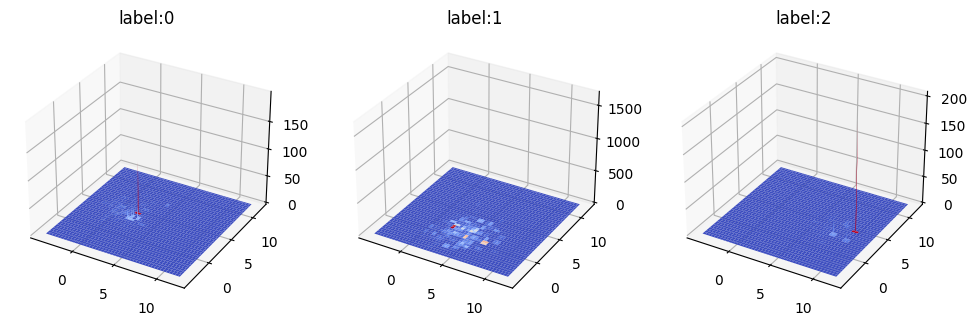

X1 k=3


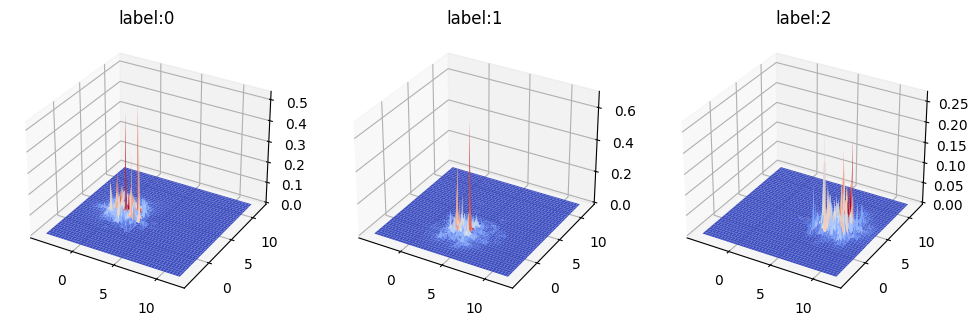

X1 k=5


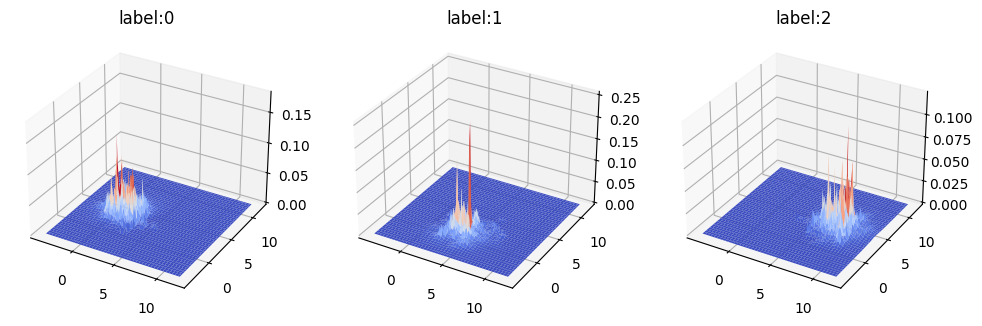

X2 k=1


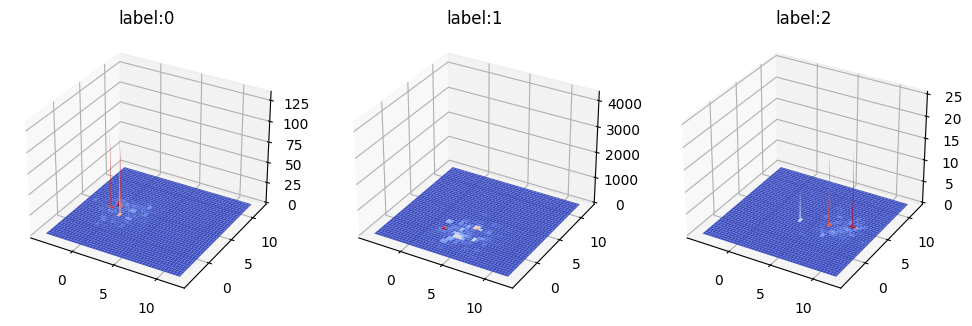

X2 k=3


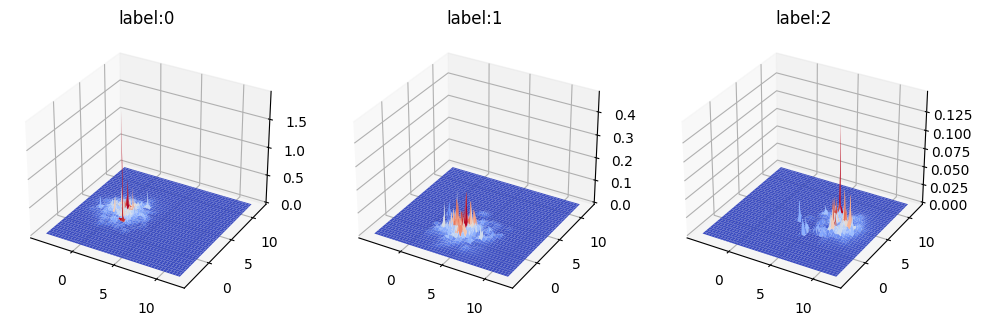

X2 k=5


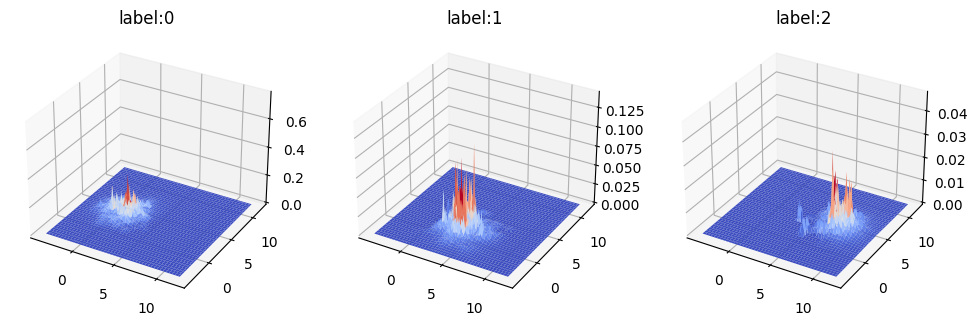

In [10]:
print("X1 k=1")
knn_draw(X1,1)
print("X1 k=3")
knn_draw(X1,3)
print("X1 k=5")
knn_draw(X1,5)
print("X2 k=1")
knn_draw(X2,1)
print("X2 k=3")
knn_draw(X2,3)
print("X2 k=5")
knn_draw(X2,5)

从上述结果可以看出，随着K从1增加到3、最后到5，概率密度估计的结果越来越接近于原始分布，k=1时估计结果极为尖锐，某些点的估计分布密度能达到二位数或三位数；随着k的增大，对测试点的分类结果随着感知到的信息增多变得更加准确，对应三维图的表现为更加平缓，分布也更加接近真实分布。